In [5]:
# Importam dependențele necesare

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# IterativeImputer e un feature experimental in skleaern, astfel că trebuie de specificat că urmează să fie imported
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
#Câțiva regressors suplimentari
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14936 entries, 0 to 14935
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Set_ID            14936 non-null  object 
 1   Name              14936 non-null  object 
 2   Year              14936 non-null  int64  
 3   Theme             14936 non-null  object 
 4   Theme_Group       14915 non-null  object 
 5   Subtheme          11495 non-null  object 
 6   Category          14936 non-null  object 
 7   Packaging         14936 non-null  object 
 8   Num_Instructions  14936 non-null  int64  
 9   Availability      14936 non-null  object 
 10  Pieces            13133 non-null  float64
 11  Minifigures       7686 non-null   float64
 12  Owned             14771 non-null  float64
 13  Rating            14936 non-null  float64
 14  USD_MSRP          5837 non-null   float64
 15  Total_Quantity    12276 non-null  float64
 16  Current_Price     5442 non-null   float6

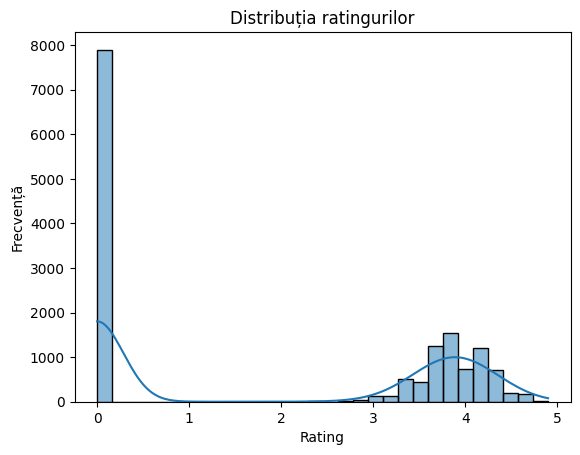

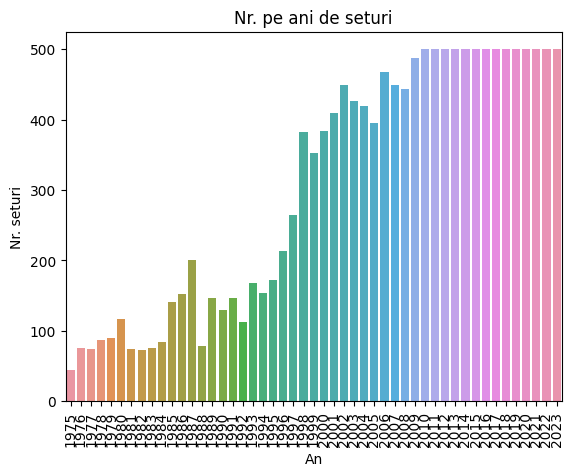

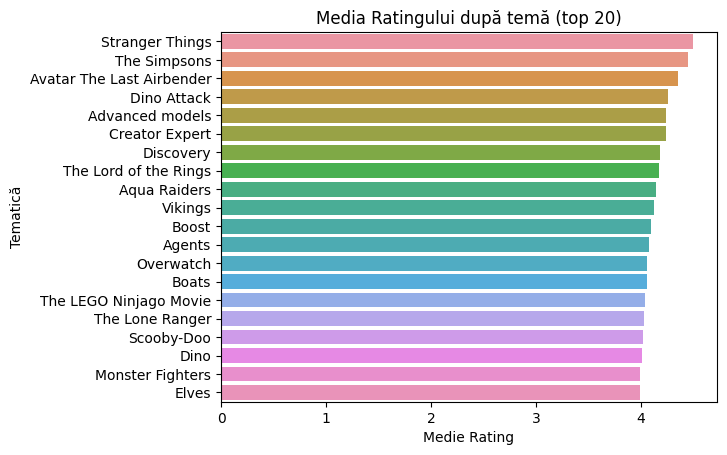

<ipython-input-6-69c9b82afad1>:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


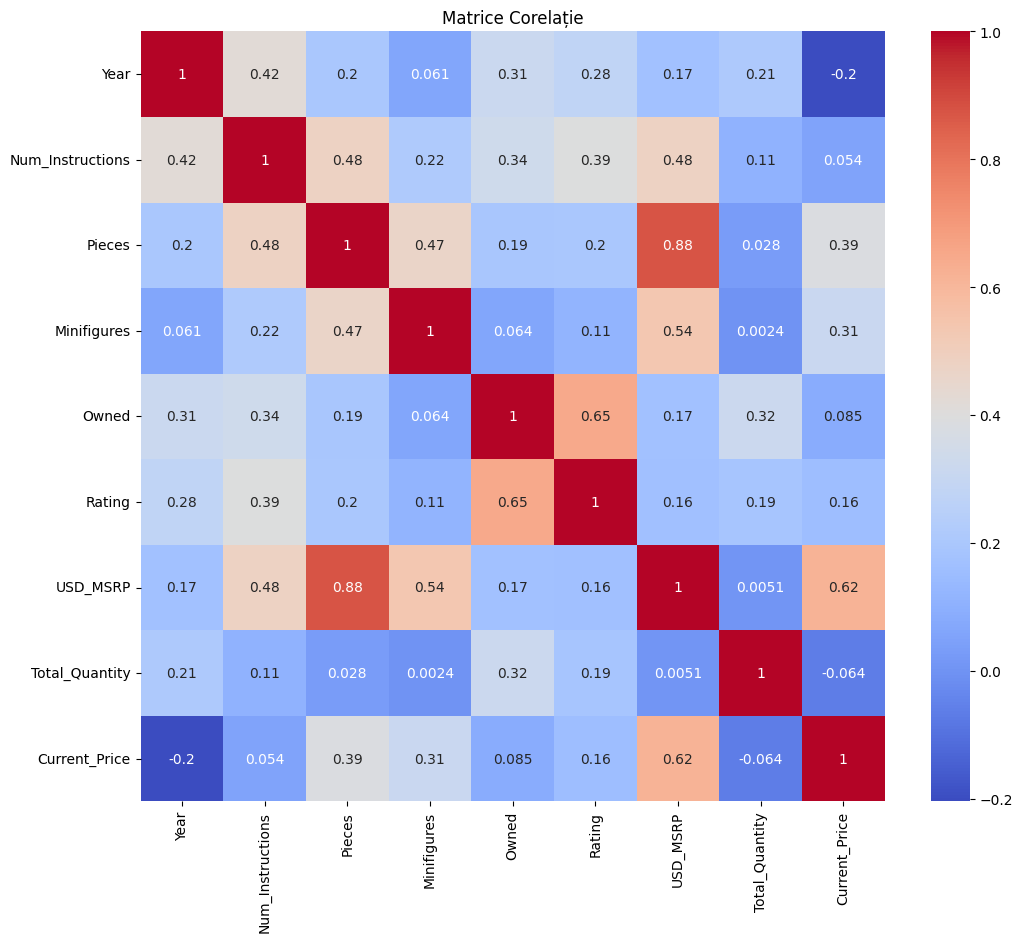

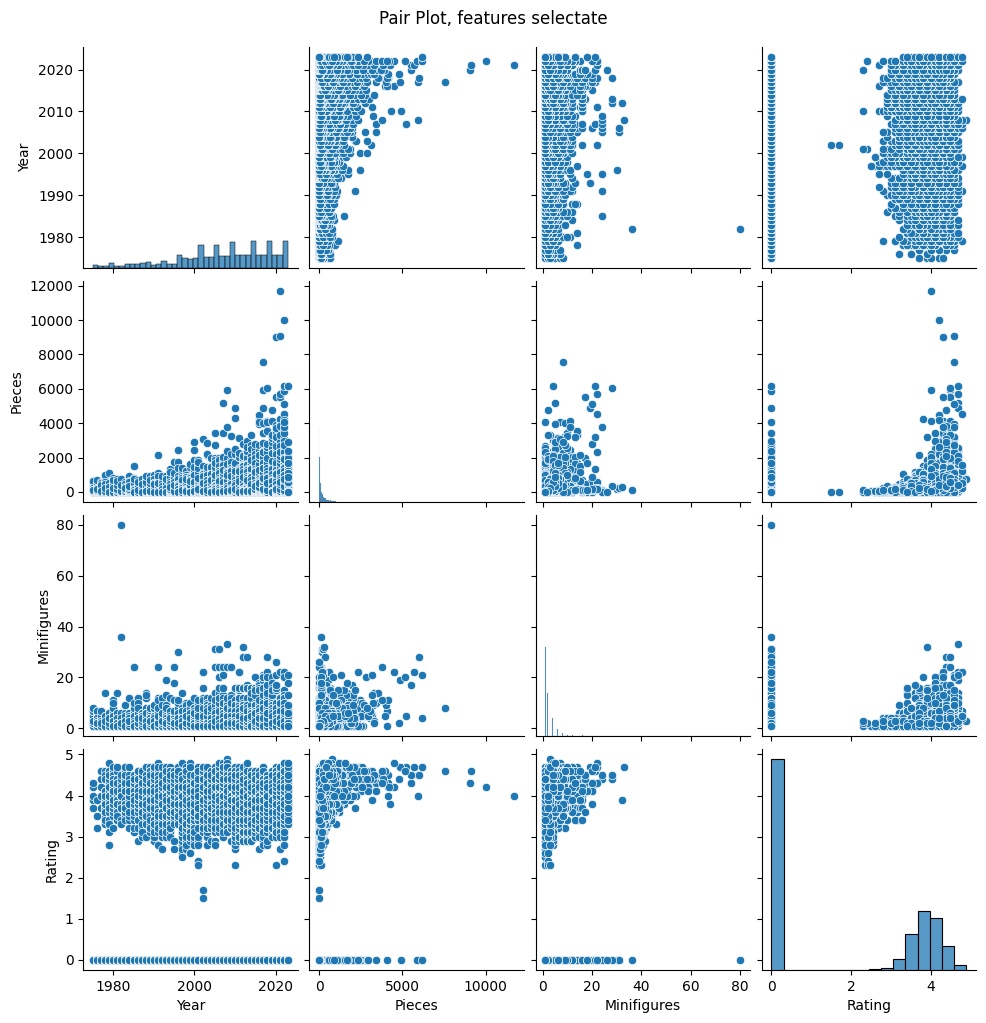

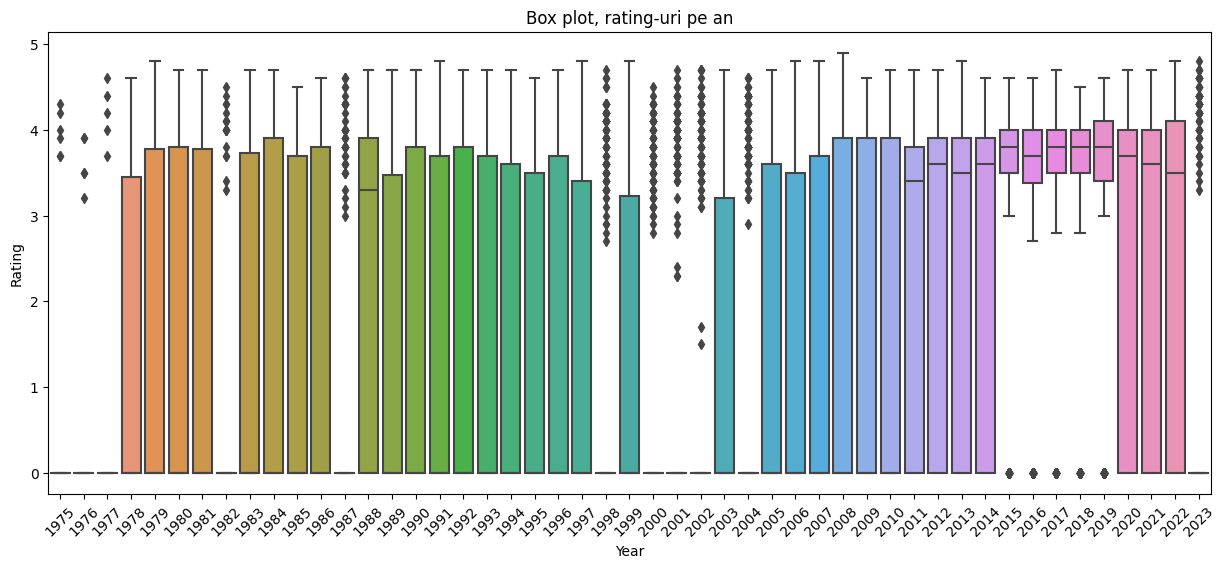

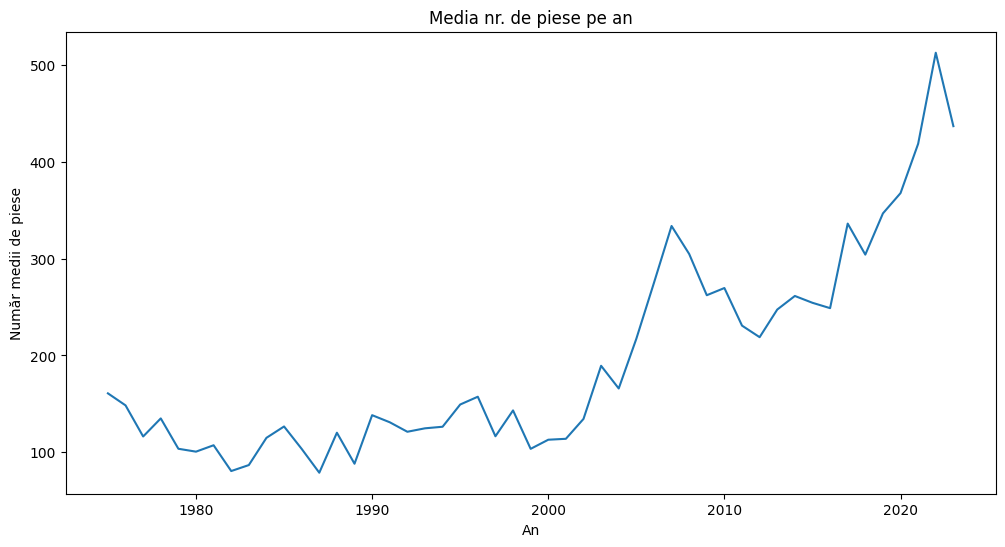

In [6]:
data = pd.read_csv('data.csv')

# Info de bază
print(data.info())
print(data.head())

# Distribuția ratingurilor
sns.histplot(data=data, x="Rating", kde=True, bins=30)
plt.title("Distribuția ratingurilor")
plt.xlabel("Rating")
plt.ylabel("Frecvență")
plt.show()

# Nr. pe ani de seturi
sns.countplot(x='Year', data=data)
plt.title('Nr. pe ani de seturi')
plt.xlabel('An')
plt.xticks(rotation=90)
plt.ylabel('Nr. seturi')
plt.show()

# Media Ratingului după temă (top 20)
theme_avg_rating = data.groupby('Theme')['Rating'].mean().sort_values(ascending=False).head(20)
sns.barplot(x=theme_avg_rating.values, y=theme_avg_rating.index)
plt.title('Media Ratingului după temă (top 20)')
plt.xlabel('Medie Rating')
plt.ylabel('Tematică')
plt.show()

# Matrice Corelație
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice Corelație')
plt.show()

selected_features = ['Year', 'Pieces', 'Minifigures', 'Rating']
sns.pairplot(data[selected_features])
plt.suptitle("Pair Plot, features selectate", y=1.02)
plt.show()

# Box plot, rating-uri pe an
plt.figure(figsize=(15, 6))
sns.boxplot(x='Year', y='Rating', data=data)
plt.title('Box plot, rating-uri pe an')
plt.xticks(rotation=45)
plt.show()

# Media nr. de piese pe an
plt.figure(figsize=(12, 6))
year_avg_pieces = data.groupby('Year')['Pieces'].mean()
sns.lineplot(x=year_avg_pieces.index, y=year_avg_pieces.values)
plt.title('Media nr. de piese pe an')
plt.xlabel('An')
plt.ylabel('Număr medii de piese')
plt.show()

In [7]:
def evaluate_imputation(imputer, X, y):
    X_imputed = imputer.fit_transform(X)
    model = LinearRegression()
    model.fit(X_imputed, y)
    y_pred = model.predict(X_imputed)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2

In [8]:
# Features pentru imputation
numerical_data = data.select_dtypes(include=['number']).drop(['Rating'], axis=1)
y = data['Rating']


imputers = {
    "Mean Imputation": SimpleImputer(strategy='mean'),
    "Median Imputation": SimpleImputer(strategy='median'),
    "KNN Imputation": KNNImputer(n_neighbors=5),
    "MICE Imputation": IterativeImputer(estimator=RandomForestRegressor(), random_state=0)
}

In [9]:
# Evaluăm separat fiecare metodă de imputation
imputation_results = {}
for name, imputer in imputers.items():
    mse, r2 = evaluate_imputation(imputer, numerical_data, y)
    imputation_results[name] = (mse, r2)

# Afișăm rezultatele pentru fiecare metodă de imputation separat
for method, (mse, r2) in imputation_results.items():
    print(f"{method}: Mean Squared Error = {mse}, R-squared Scor = {r2}")

Mean Imputation: Mean Squared Error = 2.047707683529782, R-squared Scor = 0.4619497645310656
Median Imputation: Mean Squared Error = 2.0135234287948323, R-squared Scor = 0.47093192856620003
KNN Imputation: Mean Squared Error = 2.0394961071925524, R-squared Scor = 0.4641074165325473
MICE Imputation: Mean Squared Error = 1.9995272038718117, R-squared Scor = 0.4746095394752563


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
knn_imputer = KNNImputer(n_neighbors=5)
numerical_data_imputed = knn_imputer.fit_transform(numerical_data)

# Standart Scaling pentru features numerical, One-hot encoding pentru features categorical
categorical_cols = data.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_data.columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [11]:
# Combinăm numerical și categorical data
X = pd.concat([pd.DataFrame(numerical_data_imputed, columns=numerical_data.columns), data[categorical_cols]], axis=1)

# Training data, testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Modelele!
Am adăugat câteva modele în plus pe care nu le-am trecut în cadrul cursului (la examenul precedant mi s-a zis că prea
am simplificat codul, de această dată am decis să citesc și niște informație suplimentară pe lângă carte).

Pot explica în termeni simpli ce face fiecare din cele adăugatoare, și desigur pot explica mai multe în cadrul prezentării

#Ridge Regression

Un model similar cu Linear Regression, doar că utilizat în cazurile în care avem problema de overfitting. Lucrează prin adăgaurea unui bias pentru estimările regresiei obișnuite.

#Lasso Regression

Aplică o penalitate feature-urilor care nu sunt atât de importante pentru rezultatul final (o modificare la linear regression)

#AdaBoost (Adaptive Boost)

O metodă prin care fiecare model consecutiv (cel mai des un decision tree) se focusează pe feature-urile care sunt cele mai greșite în varianta precedentă a modelului.

#Gradient Boosting

La fel, fiecare model consecutiv se focusează pe corectarea erorilor modelului precedent, doar că AdaBoost lucrează prin focusarea pe exemplele cele mai greșite, pe când Gradient Boosting lucrează prin optimizarea unui Loss Function. Există aici un risc de overfitting.

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=0),
    "AdaBoost": AdaBoostRegressor(random_state=0),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

In [13]:
model_performance = {}
for model_name, model in models.items():
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', SelectKBest(score_func=f_regression, k=20)),
        ('model', model)
    ])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    model_performance[model_name] = r2_score(y_test, y_pred)

In [14]:
for model_name, performance in model_performance.items():
    print(f"{model_name}: R-squared = {performance:.3f}")

Linear Regression: R-squared = 0.602
Ridge Regression: R-squared = 0.602
Lasso Regression: R-squared = 0.156
Random Forest: R-squared = 0.892
Gradient Boosting: R-squared = 0.883
AdaBoost: R-squared = 0.835
Support Vector Regression: R-squared = 0.819
K-Nearest Neighbors: R-squared = 0.826


In [15]:
# Gradient Boosting: R-squared = 0.883 - Modelul cel mai bun din cele suplimentare

# KNN: R-squared = 0.826 Modelul cel mai bun din cele studiate în cadrul lecțiilor